# Objetivo

Predecir el género de canciones a partir de su letra. Para ello usaremos un modelo transformers basado en BERT.

# Obtención del dataset

Primero de todos importamos las librerías necesarias para trabajar.

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
import re
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import torch

In [37]:
# Detectar device (GPU si está disponible, si no CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

Usando device: cuda


In [38]:
from google.colab import drive  # API para montar Google Drive en Colab
drive.mount('/content/drive')  # montar drive en el directorio /content/drive (Colab)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
path = '/content/drive/MyDrive/spotify_dataset_50000.csv'
df = pd.read_csv(path)
df = df[['text', 'Genre']]

# Preprocesamiento del dataset

## Limpieza

Observamos que estamos frente a un problema multiclase. Por tanto, lo primero que vamos a hacer es ajustar la columna "Genre". Como viene en formato string, lo pasaremos a formato lista.

In [40]:
# Convertir la columna 'Genre' de string ("a, b") a lista ['a','b']
df["genre_list"] = df["Genre"].apply(lambda x: [g.strip() for g in x.split(",")])  # split y strip por cada género
df.drop(columns=["Genre"], inplace=True)  # eliminar la columna original ya convertida

Agrupamos géneros similares para que no haya tantos y el modelo aprenda mejor

In [41]:
def agrupar_generos(lista_generos_original):
    # Diccionario de reglas: Palabras clave -> Macro-Género
    reglas = {
        # 1. Metal
        'metal': 'Metal', 'death': 'Metal', 'thrash': 'Metal', 'doom': 'Metal',
        'grind': 'Metal', 'screamo': 'Metal', 'hardcore': 'Metal',

        # 2. Hip-Hop
        'rap': 'Hip-Hop', 'hop': 'Hip-Hop', 'trap': 'Hip-Hop', 'grime': 'Hip-Hop',
        'drill': 'Hip-Hop',

        # 3. Punk / Rock (El orden importa, Punk antes que Rock general)
        'punk': 'Rock', 'emo': 'Rock',

        # 4. Rock
        'rock': 'Rock', 'grunge': 'Rock', 'britpop': 'Rock', 'new wave': 'Rock',
        'shoegaze': 'Rock', 'visual kei': 'Rock',

        # 5. Electronic
        'electro': 'Electronic', 'techno': 'Electronic', 'house': 'Electronic',
        'trance': 'Electronic', 'dub': 'Electronic', 'bass': 'Electronic',
        'disco': 'Electronic', 'dance': 'Electronic', 'ambient': 'Electronic',
        'chill': 'Electronic', 'lo-fi': 'Electronic', 'synth': 'Electronic',

        # 6. Pop
        'pop': 'Pop', 'j-pop': 'Pop', 'k-pop': 'Pop', 'boy band': 'Pop',

        # 7. Folk/Country
        'folk': 'Folk/Country', 'country': 'Folk/Country', 'acoustic': 'Folk/Country',
        'bluegrass': 'Folk/Country',

        # 8. R&B/Soul/Jazz
        'rnb': 'R&B/Soul', 'soul': 'R&B/Soul', 'funk': 'R&B/Soul', 'gospel': 'R&B/Soul',
        'jazz': 'Jazz/Blues', 'blues': 'Jazz/Blues', 'swing': 'Jazz/Blues',

        # 9. Reggae/Latin
        'reggae': 'Reggae/Latin', 'dancehall': 'Reggae/Latin', 'latin': 'Reggae/Latin',
        'reggaeton': 'Reggae/Latin', 'salsa': 'Reggae/Latin',

        # 10. Indie/Alternative
        'indie': 'Alternative', 'alternative': 'Alternative', 'experimental': 'Alternative',

        # 11. Otros
        'christian': 'Religious', 'worship': 'Religious',
        'comedy': 'Comedy', 'soundtrack': 'Soundtrack', 'classical': 'Classical'
    }

    nuevos_generos = set()

    for genero in lista_generos_original:
        genero_norm = genero.lower().strip()

        # Buscamos si alguna palabra clave está en el género actual
        for key, macro in reglas.items():
            if key in genero_norm:
                nuevos_generos.add(macro)
                break

    return list(nuevos_generos)

# 1. Aplicamos la función a la columna que ya tenías
df['genre_list'] = df['genre_list'].apply(agrupar_generos)

# 2. Filtramos canciones que se hayan quedado sin género (por si acaso)
df = df[df['genre_list'].map(len) > 0]

# 3. Verificamos cómo ha quedado
print("Nuevos géneros únicos detectados:")
print(df['genre_list'].explode().unique())

Nuevos géneros únicos detectados:
['Hip-Hop' 'Rock' 'Pop' 'Electronic' 'Folk/Country' 'Metal' 'Classical'
 'Soundtrack' 'Comedy' 'Jazz/Blues' 'Alternative' 'R&B/Soul'
 'Reggae/Latin' 'Religious']


Una vez hecho esto, vamos a tratar las letras de las canciones. Vamos a eliminar los corchetes y la información que aparece dentro de ellos.

In [42]:
def limpiar_corchetes(texto):  # definir función para eliminar contenido entre corchetes
    # Esto elimina cualquier cosa entre [], incluyendo los corchetes
    return re.sub(r"\[.*?\]", "", texto).strip()  # sustituir por vacío y quitar espacios exteriores

# Aplicar la limpieza a la columna de texto y guardar en 'clean_text'
df['clean_text'] = df['text'].apply(limpiar_corchetes)  # limpiar corchetes de cada letra
df.drop(columns=['text'], inplace=True)  # eliminar la columna original de texto

Vamos ahor a detectar el idioma de las letras de las canciones. Será de vital importancia a la hora de elegir el modelo, ya que un modelo monolingüe es menos pesado y tardará menos en entrenar. La idea es quedarnos con el modelo RoBERTa si aparece un único idioma (o si el 90% de las canciones son en inglés). En otro caso usaremos la versión multilingüe de RoBERTa.

Analizando idiomas...

--- Distribución de Idiomas (%) ---
idioma
en    97.140971
id     0.502181
so     0.432156
tl     0.336121
af     0.234084
Name: proportion, dtype: float64

Total canciones antes: 49982
Total canciones después de filtrar (Solo Inglés): 48553


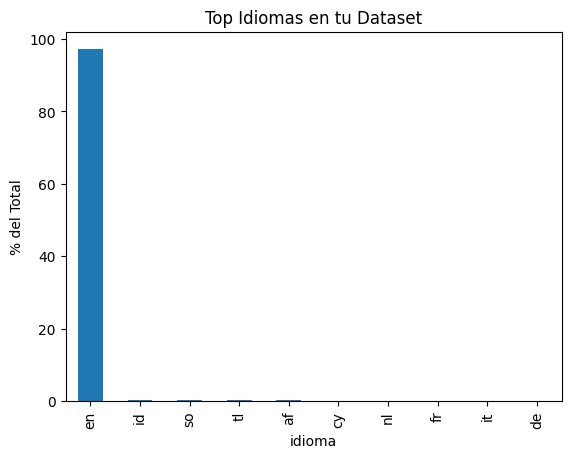

In [44]:
# 1. Instalar librería de detección (ligera y rápida)
!pip install langdetect

from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt

def detectar_idioma(texto):
    try:
        # Cogemos solo los primeros 100 caracteres para ir rápido
        # (Suficiente para saber si es inglés o español)
        return detect(texto[:100])
    except LangDetectException:
        return "unknown"

# 2. Aplicar al dataset (tardará unos 2-3 minutos para 50k)
print("Analizando idiomas...")
# Usamos una muestra si quieres ir ultra-rápido, o todo el df si quieres precisión
# df_sample = df.sample(5000)
df['idioma'] = df['clean_text'].apply(detectar_idioma)

# 3. Ver resultados
conteo_idiomas = df['idioma'].value_counts(normalize=True) * 100
print("\n--- Distribución de Idiomas (%) ---")
print(conteo_idiomas.head(5))

# --- AQUÍ ES DONDE VA LA LÍNEA NUEVA ---
print(f"\nTotal canciones antes: {len(df)}")
df = df[df['idioma'] == 'en']
print(f"Total canciones después de filtrar (Solo Inglés): {len(df)}")

# 4. Gráfica rápida
conteo_idiomas.head(10).plot(kind='bar', title='Top Idiomas en tu Dataset')
plt.ylabel('% del Total')
plt.show()

Ahora vamos a pasar a binarizar la variable Genre.

In [45]:
mlb = MultiLabelBinarizer()  # crear binarizador para etiquetas multilabel
labels = mlb.fit_transform(df['genre_list'])  # ajustar a las listas de géneros y transformar a matriz binaria
df['labels_binarios'] = list(labels)  # almacenar vectores binarios como lista en DataFrame
generos_unicos = mlb.classes_  # obtener nombres de géneros únicos
num_labels = len(generos_unicos)  # contar cuántas etiquetas existen

In [46]:
print(f"Géneros únicos: {generos_unicos}")  # mostrar la lista de géneros
print(f"Número de géneros únicos: {num_labels}")  # mostrar el número de etiquetas disponibles
print(labels)

Géneros únicos: ['Alternative' 'Classical' 'Comedy' 'Electronic' 'Folk/Country' 'Hip-Hop'
 'Jazz/Blues' 'Metal' 'Pop' 'R&B/Soul' 'Reggae/Latin' 'Religious' 'Rock'
 'Soundtrack']
Número de géneros únicos: 14
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [50]:
df_final = df[['clean_text', 'labels_binarios']].copy()  # seleccionar solo texto limpio y labels binarios y crear copia segura
df_final.head()

,clean_text,labels_binarios
0,Lyrics/Music Yellen/Pokrass Why are grown up p...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"Sharing's good, sharing's fine But no one w...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,"Let it go, let it go Can’t hold it back anymor...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3,"(Madara) J'S, J'S If your friend gets packed...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"""Love? You know, what do you know about love? ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


Por último vamos a borrar las canciones que aparecen repetidas

In [51]:
df_final.drop_duplicates(subset=['clean_text'], inplace=True)  # eliminar filas con letras duplicadas para evitar sesgo por duplicados

## Tokenizador

Dividimos el dataset en entrenamiento, validación y test en una proporción de 80-20-20

In [52]:
train_val_df, test_df = train_test_split(df_final, test_size=0.2, random_state=42)  # separar 20% para test
train_df , val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)  # dividir el 80% restante en train (60%) y val (20%)

Convertimos a formato Dataset de HuggingFace

In [53]:
import gc

# Convertimos a Dataset de HF
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Limpieza de RAM: borramos los dataframes de Pandas que ya no sirven y ocupan espacio
del df, df_final, train_df, val_df, test_df, train_val_df
gc.collect() # Forzamos al recolector de basura de Python a liberar memoria
print("Memoria RAM liberada. Listo para tokenizar.")

Memoria RAM liberada. Listo para tokenizar.


Cargamos el tokenizador

In [54]:
MODEL_NAME = "roberta-base"  # nombre del modelo preentrenado a usar
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)  # cargar el tokenizador correspondiente al modelo

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Función de preprocesamiento: tokenizamos y convertimos los labels a float

In [55]:
def preprocess_data(example):  # función que tokeniza y prepara labels para el modelo
    encoding = tokenizer(
        example['clean_text'],  # texto limpio a tokenizar
        padding='max_length',  # rellenar hasta la longitud máxima
        truncation=True,  # truncar si excede max_length
        max_length=512  # longitud máxima de tokens
    )  # resultado: diccionario con input_ids, attention_mask, etc.
    encoding['labels'] = [np.array(label, dtype=np.float32) for label in example['labels_binarios']]  # convertir labels a float32
    return encoding  # devolver diccionario con inputs y labels

Aplicamos la función a los datasets

In [56]:
tokenized_train_dataset = train_dataset.map(preprocess_data, batched=True,
                                            remove_columns=['clean_text', 'labels_binarios', '__index_level_0__'])  # aplicar preprocesado y eliminar columnas originales en train
tokenized_val_dataset = val_dataset.map(preprocess_data, batched=True,
                                        remove_columns=['clean_text', 'labels_binarios', '__index_level_0__'])  # aplicar a validación
tokenized_test_dataset = test_dataset.map(preprocess_data, batched=True,
                                        remove_columns=['clean_text', 'labels_binarios', '__index_level_0__'])  # aplicar a test

Map:   0%|          | 0/27791 [00:00<?, ? examples/s]

Map:   0%|          | 0/9264 [00:00<?, ? examples/s]

Map:   0%|          | 0/9264 [00:00<?, ? examples/s]

Mapeo de etiquetas y modelo

In [57]:
# Mapear índices a etiquetas y viceversa para el modelo
id2label = {i: label for i, label in enumerate(generos_unicos)}  # id -> nombre etiqueta
label2id = {label: i for i, label in enumerate(generos_unicos)}  # nombre etiqueta -> id

# Cargar modelo preentrenado para clasificación de secuencias (ajustar para multilabel)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels, # El número de géneros únicos
    problem_type="multi_label_classification", # indicar que es multilabel
    id2label=id2label,
    label2id=label2id
)  # devuelve un modelo listo para fine-tuning en multilabel

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configuramos el entrenamiento: AdamW y Early Stopping

In [58]:
# Definimos las métricas de evaluación para multi-label
def compute_metrics(eval_pred):
    logits, labels = eval_pred  # logits sin normalizar y labels verdaderas

    pred_probs = 1 / (1 + np.exp(-logits))  # Aplicar la función sigmoide para obtener probabilidades
    preds = (pred_probs >= 0.2).astype(int)  # Umbral por defecto (0.2) para convertir probabilidades a 0/1

    f1_micro = f1_score(labels, preds, average='micro', zero_division=0)  # F1 micro (suma sobre clases)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)  # F1 macro (promedio por clase)
    accuracy = accuracy_score(labels, preds)  # accuracy binaria por etiqueta
    roc_auc = roc_auc_score(labels, pred_probs, average='micro')  # ROC AUC usando probabilidades

    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'accuracy': accuracy,
        'roc_auc': roc_auc
    }

# Callback de early stopping para detener entrenamiento si no hay mejora
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3
)

# Configuramos argumentos de entrenamiento
training_args = TrainingArguments(
    # 1. SEGURIDAD: Guardamos en Drive por si Colab se desconecta
    output_dir="/content/drive/MyDrive/checkpoints_spotify_50k",
    overwrite_output_dir=False,

    # 2. VELOCIDAD: Evaluamos cada 500 pasos (aprox cada 20-30 min)
    save_strategy="steps", # Aquí sería mejor poner epochs. Pendiente de cambiar.
    save_steps=500,
    eval_strategy="steps", # Aquí sería mejor poner epochs. Pendiente de cambiar
    eval_steps=500,
    save_total_limit=2,           # Solo guardamos los 2 últimos para no llenar Drive

    # Configuración de Hardware
    learning_rate=2e-5,
    fp16=True,                    # Vital para memoria GPU
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16, # Validación más rápida

    # Configuración del Modelo
    load_best_model_at_end=True,
    num_train_epochs=3,           # 3 épocas suelen sobrar para 50k
    weight_decay=0.01,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=100,            # Logs frecuentes para ver que no se cuelga
    report_to=["none"]
)

# El trainer se mantiene igual
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# Entrenar

In [59]:
# Entrenamos
trainer.train()  # ejecutar el loop de entrenamiento

print("\nEntrenamiento completado.")

# Evaluar el mejor modelo (cargado automáticamente)
eval_results = trainer.evaluate()  # obtener métricas en el conjunto de validación
print("Resultados finales de la evaluación:")
print(eval_results)  # mostrar las métricas

# Guardar el modelo final y el tokenizador
trainer.save_model("./mi_modelo_genero_multilabel")  # guardar pesos y configuración del modelo
tokenizer.save_pretrained("./mi_modelo_genero_multilabel")  # guardar tokenizador para inferencia posterior

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy,Roc Auc
500,0.219000,0.213843,0.518770,0.108642,0.264141,0.880117
1000,0.207500,0.208097,0.522120,0.122857,0.290911,0.885278
1500,0.206600,0.204912,0.524534,0.161103,0.273100,0.890317
2000,0.202800,0.205008,0.528822,0.159564,0.277202,0.891165
2500,0.196900,0.203538,0.525928,0.170490,0.298251,0.892473
3000,0.202400,0.201901,0.528607,0.171947,0.298791,0.894595
3500,0.193200,0.199898,0.534493,0.180778,0.299007,0.896579
4000,0.191400,0.201947,0.527615,0.186838,0.307427,0.894864
4500,0.182300,0.202081,0.532036,0.198813,0.337759,0.894769
5000,0.186200,0.201640,0.527331,0.202881,0.324590,0.895011



Entrenamiento completado.


Resultados finales de la evaluación:
{'eval_loss': 0.20164000988006592, 'eval_f1_micro': 0.5273307664461776, 'eval_f1_macro': 0.20288084095622624, 'eval_accuracy': 0.32458981001727116, 'eval_roc_auc': 0.8950106645824008, 'eval_runtime': 71.3286, 'eval_samples_per_second': 129.878, 'eval_steps_per_second': 8.117, 'epoch': 3.0}


('./mi_modelo_genero_multilabel/tokenizer_config.json',
 './mi_modelo_genero_multilabel/special_tokens_map.json',
 './mi_modelo_genero_multilabel/vocab.json',
 './mi_modelo_genero_multilabel/merges.txt',
 './mi_modelo_genero_multilabel/added_tokens.json',
 './mi_modelo_genero_multilabel/tokenizer.json')

# Predicciones

In [60]:
# 1. Generar predicciones sobre el conjunto de test
output_predictions = trainer.predict(tokenized_test_dataset)

# 2. Ver las métricas
print("Métricas Finales en Test")
for key, value in output_predictions.metrics.items():
    print(f"{key}: {value:.4f}")

# 3. Visualizar ejemplos reales (Decodificar de [0,1,0] a ['Pop', 'Rock'])
from scipy.special import expit

# Obtener probabilidades y binarizar
probs = expit(output_predictions.predictions)
preds_binary = (probs >= 0.2).astype(int)

# Función auxiliar para traducir vector binario a lista de textos
def decode_labels(binary_row, id2label_map):
    return [id2label_map[i] for i, val in enumerate(binary_row) if val == 1]

print("\n Comparativa Visual (Primeras 5 canciones)")
for i in range(5):
    # Etiquetas Reales
    real_genres = decode_labels(output_predictions.label_ids[i], id2label)
    # Predicciones
    pred_genres = decode_labels(preds_binary[i], id2label)

    print(f"Canción {i+1}:")
    print(f"  🟢 Real:     {real_genres}")
    print(f"  🤖 Predicho: {pred_genres}")
    print("-" * 50)

Métricas Finales en Test
test_loss: 0.1984
test_f1_micro: 0.5387
test_f1_macro: 0.2098
test_accuracy: 0.3246
test_roc_auc: 0.8989
test_runtime: 70.1186
test_samples_per_second: 132.1190
test_steps_per_second: 8.2570

 Comparativa Visual (Primeras 5 canciones)
Canción 1:
  🟢 Real:     ['Hip-Hop']
  🤖 Predicho: ['Electronic', 'Hip-Hop', 'Pop', 'R&B/Soul']
--------------------------------------------------
Canción 2:
  🟢 Real:     ['Hip-Hop']
  🤖 Predicho: ['Hip-Hop']
--------------------------------------------------
Canción 3:
  🟢 Real:     ['Pop', 'Rock']
  🤖 Predicho: ['Rock']
--------------------------------------------------
Canción 4:
  🟢 Real:     ['Pop', 'Rock']
  🤖 Predicho: ['Hip-Hop', 'Pop', 'R&B/Soul', 'Rock']
--------------------------------------------------
Canción 5:
  🟢 Real:     ['Hip-Hop']
  🤖 Predicho: ['Folk/Country', 'Rock']
--------------------------------------------------


In [61]:
from huggingface_hub import login

# Ejecuta esto y pega tu token TOKEN DE ESCRITURA (WRITE) cuando te lo pida
login(add_to_git_credential=False)

In [62]:
from huggingface_hub import login

# 1. Loguearse (te pedirá el token)
login()

# 2. Definir el nombre de tu repositorio en el Hub
# Formato: "tu_usuario/nombre_del_modelo"
repo_id = "Juanpeg1729/genre-classifier"

# 3. Subir el modelo y el tokenizador
model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

print(f"¡Modelo subido exitosamente a https://huggingface.co/{repo_id}!")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...yllaeum/model.safetensors:   0%|          |  550kB /  499MB            

¡Modelo subido exitosamente a https://huggingface.co/Juanpeg1729/genre-classifier!
